## PHYS-467 Machine Learning for Physicists. Exercise session 4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import pickle, os
from urllib.request import urlopen 

from sklearn.linear_model import LinearRegression,LogisticRegression, Ridge, Lasso, RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification

np.random.seed(42)

# Exercise 1 : (Stochastic) Gradient Descent with Logistic regression

**Question 1.a)** Implement the sigmoid function $\sigma(x)$

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

**Question 1.b)** Generate an $n\times{d}$ random data matrix with dimension $d = 2$. Generate a random vector of optimal parameters $w_{opt}$. Generate the labels as $y = \pm 1$ from the distribution $p(y = 1 | x) = \sigma(w_{opt}^Tx)$ and $p(y = -1 | x) = 1-\sigma(w_{opt}^Tx)$  with sigma the logistic function. 

This means you have to generate labels (which are $\pm 1$) as y = 2 * np.random.binomial(1,sigmoid(X @ w_opt)) - 1.0

In [3]:
seed = 42
n = 1000
d = 2
X = np.random.randn(n, d)
w_opt = np.random.randn(d)
y = 2 * np.random.binomial(1, sigmoid(X @ w_opt)) - 1

**Question 1.c)** Verify that sigmoid(-x) = 1-sigmoid(x)

In [4]:
assert np.allclose(sigmoid(X @ w_opt), 1 - sigmoid(-(X @ w_opt)))

**Question 1.d)** Implement a function performing one step gradient descent for logistic regression. Recall that with $y = \pm 1$,  the logistic loss is $\mathcal L = - \sum_i \log \sigma(y_i \times w^T x_i)$. Implement a second function enabling multiple iterations of gradient descent. This function should return the parameters calculated at each iteration.

Rmk : compute the gradient of the logistic loss function in order to update each gradient step. For labels $y \in \{ \pm 1 \}$ the gradient of the loss is $ \nabla \mathcal L (w)= X^\top [(\sigma(y \odot (Xw)) -1)\odot y]$ where $\odot$ is the entrywise product and $ X \in \mathbb{R}^{n \times d}$, $w \in \mathbb{R}^{ d}$ and $y \in \mathbb{R}^{n }$

In [5]:
def gradient_step_logistic(X, y, w_, lr=0.01): # one step
    return w_ - lr * X.T @ ((sigmoid(y * (X @ w_)) - 1) * y)

def gradient_descent_logistic(X, y, w_init, lr=0.01, n_iter=100): # many steps
    ws = []
    w = w_init
    ws.append(w)
    for _ in range(n_iter):
        w = gradient_step_logistic(X, y, w, lr)
        ws.append(w)
    return ws

**Question 1.e)** Implement stochastic gradient descent using the gradient step function used in the previous question. Hint: you should apply the gradient step function only on a random subset of the data at each iteration (namely a batch).

In [6]:
def stochastic_gradient_descent_logistic(X, y, w_init, lr=0.01, n_iter=100):
    batch_size = 10
    ws = []
    w = w_init
    ws.append(w)
    for _ in range(n_iter):
        it_batch = np.random.randint(0, X.shape[0], batch_size)
        X_batch = X[it_batch]
        y_batch = y[it_batch]
        w = gradient_step_logistic(X_batch, y_batch, w, lr)
        ws.append(w)
    return ws

**Question 1.f)** Run both GD and SGD from the two functions above with a small learning rate  $\eta$ ($10^{-2}$ should work fine). Plot the cosine similarity between the ground truth weights and the ones found by the gradient steps at each iteration $\frac{w_t \cdot w_{\star}}{\vert{w_t}\vert\vert{w_{\star}\vert}}$ (namely correlation of overlap) as a function of the number of iterations $t$ for Gradient Descent and Stochastic Gradient Descent. 

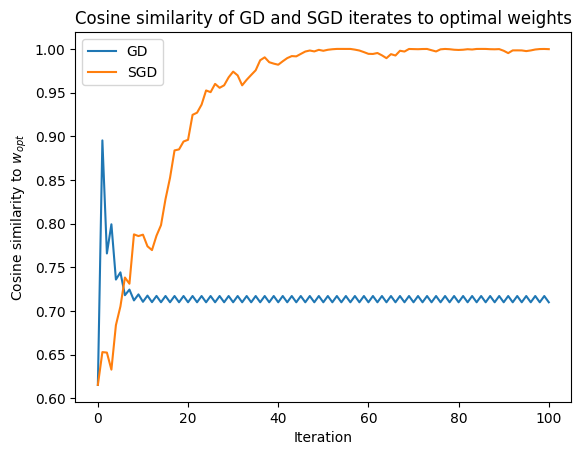

In [7]:
w_init = np.random.randn(d)
lr = 0.01
w_GD = gradient_descent_logistic(X, y, w_init, lr)
w_SGD = stochastic_gradient_descent_logistic(X, y, w_init, lr)
cosine_GD = w_GD @ w_opt / (np.linalg.norm(w_GD, axis=1) * np.linalg.norm(w_opt))
cosine_SGD = w_SGD @ w_opt / (np.linalg.norm(w_SGD, axis=1) * np.linalg.norm(w_opt))

plt.plot(cosine_GD, label='GD')
plt.plot(cosine_SGD, label='SGD')
plt.xlabel('Iteration')
plt.ylabel('Cosine similarity to $w_{opt}$')
plt.legend()
plt.title('Cosine similarity of GD and SGD iterates to optimal weights')
plt.show()

**Question 1.g)** Use sklearn's LogisticRegression with fit_intercept=False and compare its accuracy with that obtained by gd and sgd at the optimal parameters.

In [8]:
logistic_regression = LogisticRegression(fit_intercept=False)
clf = logistic_regression.fit(X, y)
clf.coef_ 
w_GD_opt = w_GD[np.argmax(cosine_GD)]
w_SGD_opt = w_GD[np.argmax(cosine_SGD)]
print("Sklearn Logistic Regression Coefficients:", clf.coef_)
print("GD Optimal Weights:", w_GD_opt)
print("SGD Optimal Weights:", w_SGD_opt)

Sklearn Logistic Regression Coefficients: [[-0.71451927 -0.17235731]]
GD Optimal Weights: [-1.0648051 -0.848097 ]
SGD Optimal Weights: [-0.94074606  0.60356446]


**Question 1.h)** In this question we look at the role of the learning rate in the convergence of gradient descent. Run GD with a large learning rate (say $\eta$ = 10.0), and observe that GD does not converge.

/var/folders/ml/mckm5tb169sckcm9zfghvmm80000gn/T/ipykernel_42713/1253679003.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


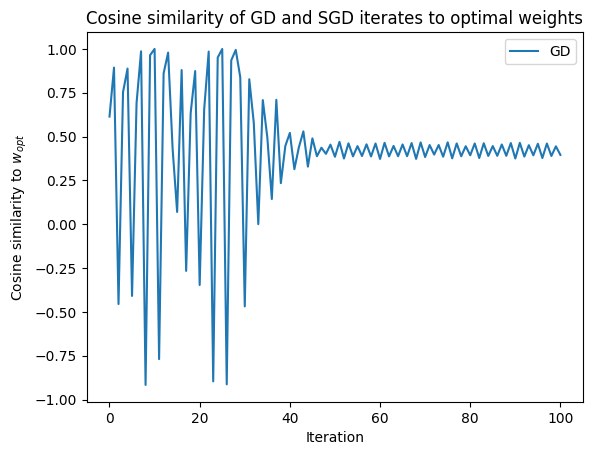

In [9]:
w_init = np.random.randn(d)
lr = 10
w_GD = gradient_descent_logistic(X, y, w_init, lr)
cosine_GD = w_GD @ w_opt / (np.linalg.norm(w_GD, axis=1) * np.linalg.norm(w_opt))

plt.plot(cosine_GD, label='GD')
plt.xlabel('Iteration')
plt.ylabel('Cosine similarity to $w_{opt}$')
plt.legend()
plt.title('Cosine similarity of GD and SGD iterates to optimal weights')
plt.show()

# Exercise 2: LASSO

**Question 2.a)** Generate a $n\times{d}$ matrix with entries drawn from a Gaussian with zero mean and unit variance. Choose $n=300$ and $d=10$.

In [10]:
n = 300
d = 10
X = np.random.normal(0, 1, (n, d))

**Question 2.b)** Given the vector $w_{opt}$ provided below, print it and use it to generate the training and testing labels. Corrupt the labels with zero-mean unit-variance Gaussian noise

In [11]:
d=10
w_opt = np.random.choice([0,1,-1], d ,p=[0.7,0.15,0.15])
print("True weights:", w_opt)
noise = np.random.normal(0, 1, (n))
y = X @ w_opt + noise

True weights: [0 0 0 1 0 0 0 0 1 0]


**Question 2.c)** Perform linear regression on the training data and print: a) the so-found coefficients and the train error

In [12]:
linear_regression = LinearRegression(fit_intercept=False)
clf = linear_regression.fit(X, y)
print("Sklearn Linear Regression Coefficients:", clf.coef_)
y_pred = clf.predict(X)
train_mse = np.mean(y - y_pred)
print("Training MSE:", train_mse)

Sklearn Linear Regression Coefficients: [ 0.02060781  0.0017935   0.02113276  0.97658806 -0.06462177 -0.01111187
 -0.01406755  0.08799217  1.000785   -0.05650666]
Training MSE: 0.03479768704202847


**Question 2.d)** Fit sklearn's LASSO on the training data and print: a) the so-found coefficients and the train error. Fix the regularization to 0.1. Look at the coefficients, what do you notice?

In [13]:
LASSO = Lasso(alpha=0.1, fit_intercept=False)
clsf_lasso = LASSO.fit(X, y)
print("Sklearn Lasso Coefficients:", LASSO.coef_)
y_pred = LASSO.predict(X)
train_mse_LASSO = np.mean(y - y_pred)
print("Training MSE:", train_mse_LASSO)

Sklearn Lasso Coefficients: [ 0.         -0.          0.          0.88325295 -0.         -0.
 -0.          0.          0.87627961 -0.        ]
Training MSE: 0.04329116441988614


**Question 2.e)** Use cross validation to find the optimal value of the regularization strength in Lasso. Plot the different coefficients as a function of $\lambda$ 

Sklearn LASSO Coefficients (alpha=0.0): [ 0.02060781  0.0017935   0.02113276  0.97658806 -0.06462177 -0.01111187
 -0.01406755  0.08799217  1.000785   -0.05650666]
Sklearn LASSO Coefficients (alpha=0.1): [ 0.         -0.          0.          0.88325295 -0.         -0.
 -0.          0.          0.87627961 -0.        ]
Sklearn LASSO Coefficients (alpha=0.2): [ 0.         -0.          0.          0.78969061 -0.         -0.
 -0.          0.          0.76241604 -0.        ]
Sklearn LASSO Coefficients (alpha=0.30000000000000004): [ 0.         -0.          0.          0.69612835 -0.         -0.
 -0.          0.          0.64855247 -0.        ]
Sklearn LASSO Coefficients (alpha=0.4): [ 0.         -0.          0.          0.60256609 -0.         -0.
 -0.          0.          0.5346889  -0.        ]
Sklearn LASSO Coefficients (alpha=0.5): [ 0.         -0.          0.          0.50900383 -0.         -0.
 -0.         -0.          0.42082533 -0.        ]
Sklearn LASSO Coefficients (alpha=0.6000000000

/Users/user/Desktop/EPFL/MA1/Machine Learning/.venv/lib/python3.12/site-packages/sklearn/base.py:1365: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/user/Desktop/EPFL/MA1/Machine Learning/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/user/Desktop/EPFL/MA1/Machine Learning/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.295e+02, tolerance: 8.283e-02
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of 

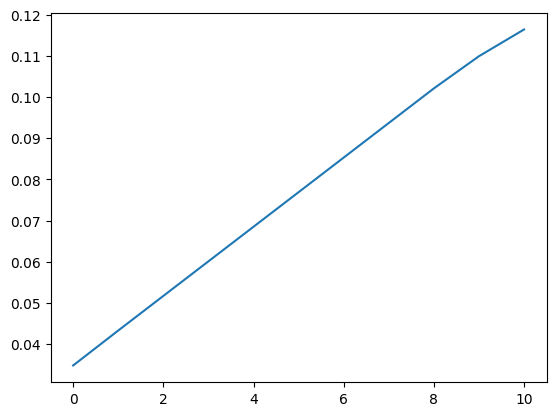

In [14]:
train_mse_LASSO_tab = []

for alpha in np.arange(0, 1.1, 0.1):
    LASSO = Lasso(alpha=alpha, fit_intercept=False)
    clsf_ridge = LASSO.fit(X, y)
    print(f"Sklearn LASSO Coefficients (alpha={alpha}):", LASSO.coef_)
    y_pred = LASSO.predict(X)
    train_mse_LASSO_tab.append(np.mean(y - y_pred))

plt.plot(train_mse_LASSO_tab, label='LASSO')

# Exercise 3: Ridge Classification, Logistic Regression

In this exercise we first consider a synthetic dataset to compare Ridge and Logistic regression for classification

**Question 3.a)** Use the sklearn function make_classification to generate 1000 data samples in 2 dimension. Use the following arguments: n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=12. Then use train_test_split with the following arguments X, y, test_size=0.2, random_state=42, to generate training and test splits.

In [29]:
n_samples = 1000 
n_features = 2
n_informative = 2
n_redundant = 0
n_clusters_per_class = 1
random_state = 42
X, y = make_classification(n_samples=n_samples, n_features=n_features, n_informative=n_informative, n_redundant=n_redundant, n_clusters_per_class=n_clusters_per_class, random_state=random_state)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y) 

**Question 3.b)** Make a scatter plot of the training data. Color each point according to its cluster assignment. _Hint_ : To change the color as a function of the label, use the option `c=y` in `plt.scatter`.

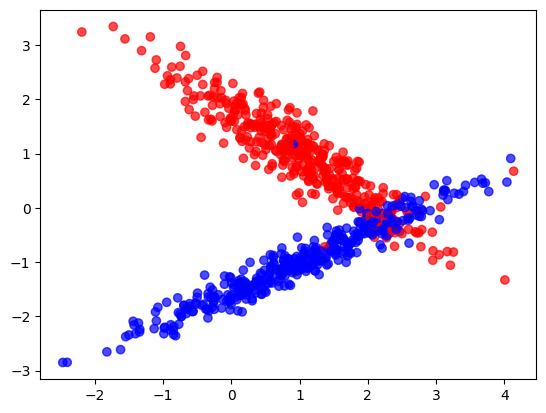

In [30]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr', alpha=0.7)

**Question 3.c)** Train a ridge classifier and a logistic regression using sklearn. Compare the results in terms of accuracy.

In [31]:
Ridge_classifier = RidgeClassifier()
clsf_ridge = Ridge_classifier.fit(X_train, y_train)
y_pred = clsf_ridge.predict(X_test)
accuracy_ridge = accuracy_score(y_test, y_pred)
print("Ridge Classifier Accuracy:", accuracy_ridge)

logistic_regression = LogisticRegression()
clf = logistic_regression.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_logistic = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", accuracy_logistic)

Ridge Classifier Accuracy: 0.895
Logistic Regression Accuracy: 0.9


**Question 3.d)** Plot the decision boundaries of the two models 

In [18]:
def plot_decision_boundaries(X_test,y_test,ridge_classifier, logistic_regression, accuracy_ridge,accuracy_logistic):
    """
    arguments : 
        - X_test, y_test : test data
        - ridge_classifier : instance of the class RidgeClassifier
        - logistic_regression : instance of the class LogisticRegression
        - accuracy_ridge : accuracy of the ridge classifier
        - accuracy_logistic : accuracy of the logistic regression
    """
    # Plot the decision boundary for Ridge Classifier
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm')
    plt.title(f"Ridge Classifier\nAccuracy: {accuracy_ridge:.2f}")
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50))
    Z = ridge_classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='k')
    
    # Plot the decision boundary for Logistic Regression
    plt.subplot(1, 2, 2)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm')
    plt.title(f"Logistic Regression\nAccuracy: {accuracy_logistic:.2f}")
    ax = plt.gca()
    Z = logistic_regression.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.8)
    
    plt.show()

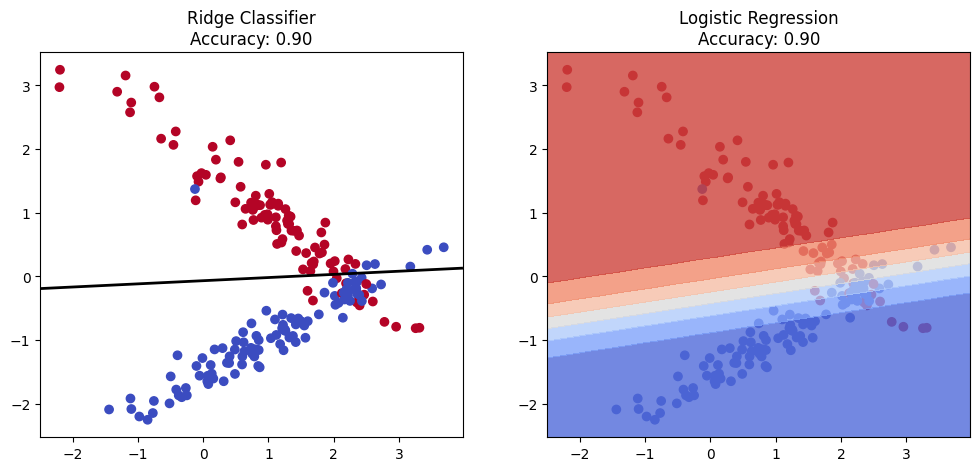

In [19]:
plot_decision_boundaries(X_test,y_test,Ridge_classifier, logistic_regression, accuracy_ridge,accuracy_logistic)

**Question 3.e)** Implement ridge classification from scratch. Implement two functions: one should return the weights and biases, the other should return the classification results given the inputs and the previously obtained coefficients. Add the option to include a regularization parameter.

In [20]:
def ridge_classifier_train(X,y,alpha):
    n_samples, n_features = X.shape
    I = np.eye(n_features)
    coef_ = np.linalg.inv(X.T @ X + alpha * I) @ X.T @ y
    intercept_ = 0
    return coef_, intercept_

def ridge_classifier_predict(X,coef_,intercept_):
    preds = X @ coef_ + intercept_
    return np.sign(preds)

**Question 3.f)** Plot the decision boundary and compare it with that obtained via sklearn. Use alpha = 1.

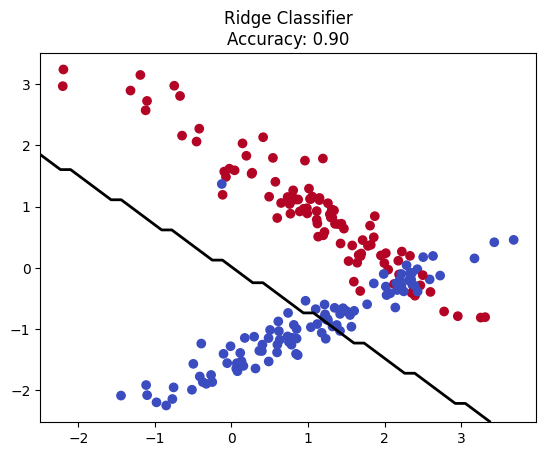

In [21]:
coef_, intercept_ = ridge_classifier_train(X,y,alpha = 1)
y_pred = ridge_classifier_predict(X,coef_,intercept_)

plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm')
plt.title(f"Ridge Classifier\nAccuracy: {accuracy_ridge:.2f}")
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50))
Z = ridge_classifier_predict(np.c_[xx.ravel(), yy.ravel()],coef_,intercept_)
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='k')

# Exercise 4: Classification on the Ising model 

We will now apply regression to the Ising model to predict the phase of the system. 

In [22]:
# Ising model parameters

L=40 # linear system size
J=-1.0 # Ising interaction
#T=np.linspace(0.25,4.0,16) # set of temperatures
T_c=2.26 # Onsager critical temperature in the TD limit

**Question 4.a)**

1) Load the data using the provided function `load_data`, then split the data in three categories : the first **70000** samples are configurations in the **ordered** phase, the next **30000** samples are in the **critical** phase and the last **60000** samples are in the **disordered** phase.

2) Merge the ordered and disordered samples together, use half of them for a training set and the rest for a validation set.

In [23]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

def load_data():
    """
    Loads the data of the Ising model. The labels correspond to ordered (1) and disordered states (0).
    """
    # url to data
    url_main = 'https://physics.bu.edu/~pankajm/ML-Review-Datasets/isingMC/';
    ######### LOAD DATA
    # The data consists of 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25):
    data_file_name = "Ising2DFM_reSample_L40_T=All.pkl" 
    # The labels are obtained from the following file:
    label_file_name = "Ising2DFM_reSample_L40_T=All_labels.pkl"
    #DATA
    data = pickle.load(urlopen(url_main + data_file_name)) # pickle reads the file and returns the Python object (1D array, compressed bits)
    data = np.unpackbits(data).reshape(-1, 1600) # Decompress array and reshape for convenience
    data=data.astype('int')
    data[np.where(data==0)]=-1 # map 0 state to -1 (Ising variable can take values +/-1)

    #LABELS (convention is 1 for ordered states and 0 for disordered states)
    labels = pickle.load(urlopen(url_main + label_file_name)) # pickle reads the file and returns the Python object (here just a 1D array with the binary labels)
    return data, labels


In [24]:
def load_data_local():
    with open("data/Ising2DFM_reSample_L40_T=All.pkl", "rb") as f:
        data = pickle.load(f)
    with open("data/Ising2DFM_reSample_L40_T=All_labels.pkl", "rb") as f:
        labels = pickle.load(f)

    data = np.unpackbits(data).reshape(-1, 1600)
    data = data.astype(int)
    data[data == 0] = -1
    return data, labels

In [25]:
#data, labels = load_data()
data, labels = load_data_local()

data_ordered, labels_ordered = data[:70000], labels[:70000]
data_critical, labels_critical = data[70000:100000], labels[70000:100000]
data_disordered, labels_disordered = data[100000:], labels[100000:]

data_phase = np.vstack((data_ordered, data_disordered))
labels_phase = np.hstack((labels_ordered, labels_disordered))

data_train, data_test, labels_train, labels_test = train_test_split(data_phase, labels_phase, test_size=0.5, random_state=42)

print("Ordered:", data_ordered.shape)
print("Critical:", data_critical.shape)
print("Disordered:", data_disordered.shape)
print("Train:", data_train.shape, "Validation:", data_test.shape)

Ordered: (70000, 1600)
Critical: (30000, 1600)
Disordered: (60000, 1600)
Train: (65000, 1600) Validation: (65000, 1600)


**Question 4.b)** Plot one instance of each class

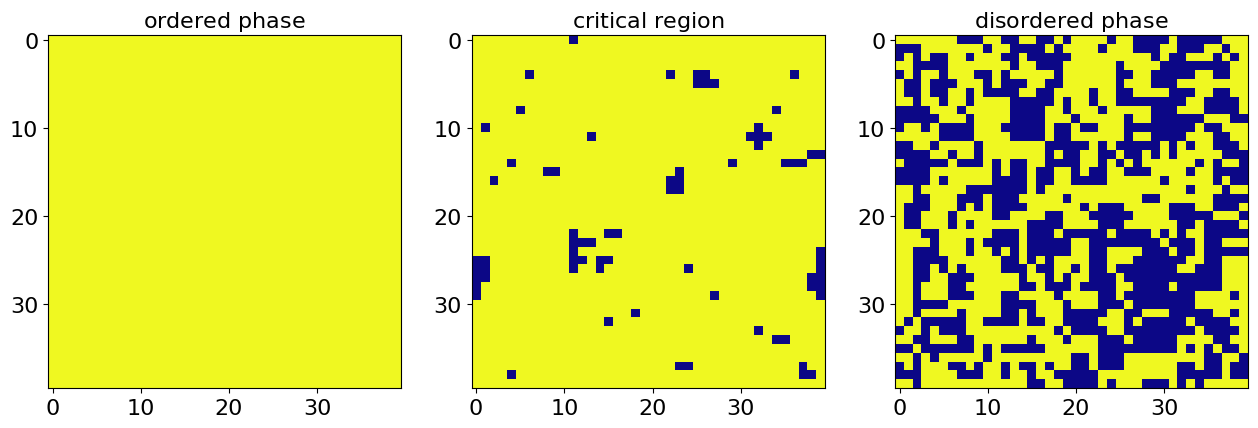

In [26]:
# set colourbar map
cmap_args=dict(cmap='plasma_r')

# plot states
fig, axarr = plt.subplots(nrows=1, ncols=3)

axarr[0].imshow(data_ordered[20001].reshape(L,L),**cmap_args)
axarr[0].set_title('$\\mathrm{ordered\\ phase}$',fontsize=16)
axarr[0].tick_params(labelsize=16)

axarr[1].imshow(data_critical[1000].reshape(L,L),**cmap_args)
axarr[1].set_title('$\\mathrm{critical\\ region}$',fontsize=16)
axarr[1].tick_params(labelsize=16)

im=axarr[2].imshow(data_disordered[50000].reshape(L,L),**cmap_args)
axarr[2].set_title('$\\mathrm{disordered\\ phase}$',fontsize=16)
axarr[2].tick_params(labelsize=16)

fig.subplots_adjust(right=2.0)

plt.show()

**Question 4.c)** Train a Ridge and Logistic regression model using different regularization and evaluate the performance on the validation set and the samples in the critical phase. What do you notice ?
_Note_ : Training the models might take some time 

In [27]:
# Ridge regression
ridge_model = Ridge(alpha=0.1, fit_intercept=False)
clf_ridge = ridge_model.fit(data_train, labels_train)
y_pred_ridge = clf_ridge.predict(data_test)

# Lasso regression
lasso_model = Lasso(alpha=0.1, fit_intercept=False)
clf_lasso = lasso_model.fit(data_train, labels_train)
y_pred_lasso = clf_lasso.predict(data_test)

# Accuracy (after rounding predictions to {0,1})
accuracy_ridge = accuracy_score(labels_test, np.round(y_pred_ridge))
accuracy_lasso = accuracy_score(labels_test, np.round(y_pred_lasso))

print("Ridge Classifier Accuracy:", accuracy_ridge)
print("Lasso Classifier Accuracy:", accuracy_lasso)

Ridge Classifier Accuracy: 0.4614923076923077
Lasso Classifier Accuracy: 0.4614923076923077


# Exercise Extra : Linear Regression (clarifications)

In this first exercise, we'll clarify the link between Gradient Descent, the pseudo-inverse and regularization for Ridge regression

**Question E.a)** Generate a random $n\times{d}$ data matrix $X$ where $n=5$ and $d=10$. Generate an $n-$ dimensional _random_ label vector $y$.

In [35]:
n = 5
d = 10
X = np.random.randn(n, d)  
y = np.random.randn(n)                                                           

**Question E.b)** Use sklearn's LinearRegression to solve the OLS problem on the previously generated data. Use the option fit_intercept=False.

In [37]:
linear_regression = LinearRegression(fit_intercept=False)
clf = linear_regression.fit(X, y)
print("Sklearn Linear Regression Coefficients:", clf.coef_)

Sklearn Linear Regression Coefficients: [-0.07367876  0.19321186 -0.73141878 -0.42167164  0.05876575  0.04880734
 -0.35582795 -0.03431663  0.44637818 -0.49457736]


**Question E.c)** Recall that the OLS solution is given by $w = (X^TX)^{-1}X^Ty$. Note that when $n<d$, the matrix $X^TX$ is not invertible and we should resort to the pseudoinverse of $X$. In this case the solution reads $w = X^T(XX^T)^{-1}y$. Write a function that returns the solution calculated in this way and compare the so-obtained coefficients with those obtained by sklearn. What can you conclude?

In [40]:
def OLS_sol(y, X):
    return X.T @ np.linalg.inv(X @ X.T) @ y

w_OLS = OLS_sol(y, X)
print("OLS Solution Coefficients:", w_OLS)

OLS Solution Coefficients: [-0.07367876  0.19321186 -0.73141878 -0.42167164  0.05876575  0.04880734
 -0.35582795 -0.03431663  0.44637818 -0.49457736]


**Question E.c)** Another way to make the matrix invertible is to do Ridge Regression. Implement a function returning the regularized solution and compare with the solution obtained by sklearn's Ridge, use $\lambda=1$ for both cases.

In [41]:
ridge = Ridge(alpha=1.0, fit_intercept=False)
clsf_ridge = ridge.fit(X, y)
print("Sklearn Ridge Coefficients:", ridge.coef_)

def ridge_sol(y, X, alpha):
    n, d = X.shape
    I = np.eye(d)
    return np.linalg.inv(X.T @ X + alpha * I) @ X.T @ y

w_ridge = ridge_sol(y, X, alpha=1.0)
print("Ridge Solution Coefficients:", w_ridge)

Sklearn Ridge Coefficients: [-0.00624298  0.05768406 -0.39768997 -0.22967662 -0.07011448  0.08128847
 -0.24147521 -0.00654952  0.2721504  -0.30374073]
Ridge Solution Coefficients: [-0.00624298  0.05768406 -0.39768997 -0.22967662 -0.07011448  0.08128847
 -0.24147521 -0.00654952  0.2721504  -0.30374073]


**Question E.d)** Use a small regularization parameter, say $\lambda = 0.001$ and compare the output of Ridge regression with the pseudo-inverse. What do you notice ?

In [42]:
ridge = Ridge(alpha=0.001, fit_intercept=False)
clsf_ridge = ridge.fit(X, y)
print("Sklearn Ridge Coefficients:", ridge.coef_)

w_OLS = OLS_sol(y, X)
print("OLS Solution Coefficients:", w_OLS)

Sklearn Ridge Coefficients: [-0.073542    0.19294788 -0.73077865 -0.42130493  0.05849337  0.04888725
 -0.35562517 -0.03426203  0.44605296 -0.4942206 ]
OLS Solution Coefficients: [-0.07367876  0.19321186 -0.73141878 -0.42167164  0.05876575  0.04880734
 -0.35582795 -0.03431663  0.44637818 -0.49457736]


**Question E.e)** Compute the square error on the training data, obtained by using the pseudoinverse coefficient and the error obtained with the regularised coefficient (with $\lambda = 0.1$). Which one do you expect to be smaller?

In [44]:
ridge = Ridge(alpha=0.1, fit_intercept=False)
clsf_ridge = ridge.fit(X, y)

y_pred_ridge = ridge.predict(X)
y_pred_OLS = X @ w_OLS

mse_ridge = np.mean((y - y_pred_ridge) ** 2)
mse_OLS = np.mean((y - y_pred_OLS) ** 2)

print("Ridge Training MSE:", mse_ridge)
print("OLS Training MSE:", mse_OLS)

Ridge Training MSE: 0.0018372679191523485
OLS Training MSE: 1.992181934474157e-31


**Question E.f)** Consider the OLS problem and implement a function performing one step of gradient descent w.r.t. the parameters. Implement a second function calling the first function for M iterations and finally returning the optimal parameters.

In [45]:
def gradient_descent_step(X,y,w,eta):
    w = w - eta * X.T @ (X @ w - y) / X.shape[0]
    return w

def train(n_iter,X,y,w,eta):
    for _ in range(n_iter):
        w = gradient_descent_step(X,y,w,eta)
    return w

**Question E.g)** Compute 1) $w_a$ the parameters obtained by initializing gradient descent with a vector of zeroes, and $w_b$ the parameters obtained by initializing gradient descent with a vector of ones. Compare both $w_a$ and $w_b$ with the solution obtained by the pseudo-inverse. What do you notice ?

In [47]:
w_a = np.zeros(d)
w_b = np.ones(d)

eta = 0.01
n_iter = 1000

w_a = train(n_iter, X, y, w_a, eta)
w_b = train(n_iter, X, y, w_b, eta)

print("Weights from zero initialization:", w_a)
print("Weights from one initialization:", w_b)

Weights from zero initialization: [-0.05545657  0.16007555 -0.65212506 -0.37662723  0.02054765  0.06203466
 -0.33379299 -0.02735241  0.40773806 -0.45204627]
Weights from one initialization: [ 1.48740171  0.35202957 -0.29356675  0.05105061  0.77891315  0.24643418
 -0.03617313  0.82192003  1.81854909 -0.15600571]


**Question E.h)** Generate a random data $n\times{d}$ matrix $X$ where $n=10$ and $d=5$. Generate an $n-$dimensional label vector $y$.

In [48]:
n = 10
d = 5
X = np.random.randn(n, d)  
y = np.random.randn(n)      

**Question E.i)** Use sklearn's LinearRegression to solve the OLS problem on the previously generated data. Use the option fit_intercept=False.

In [49]:
linear_regression = LinearRegression(fit_intercept=False)
clf = linear_regression.fit(X, y)
print("Sklearn Linear Regression Coefficients:", clf.coef_)

Sklearn Linear Regression Coefficients: [ 0.01784292 -0.18299877 -0.20764495  0.30876034 -0.08389316]


**Question E.l)** Write a function returning the standard OLS solution and compare it with the sklearn's solution

In [50]:
def OLS_sol(y, X):
    return X.T @ np.linalg.inv(X @ X.T) @ y

w_OLS = OLS_sol(y, X)
print("OLS Solution Coefficients:", w_OLS)

OLS Solution Coefficients: [ 2.44499059  0.43995496 -0.01403191  1.05964898 -0.59058309]


**Question E.m)** Compute the training error obtained by using the OLS coefficient and the error obtained with the regularised coefficient (with $\lambda = 0.1$). Which one do you expect to be smaller?

In [51]:
y_pred_OLS = X @ w_OLS
mse_OLS = np.mean((y - y_pred_OLS) ** 2)
print("OLS Training MSE:", mse_OLS)

y_pred_linear = clf.predict(X)
mse_linear = np.mean((y - y_pred_linear) ** 2)
print("Linear Regression Training MSE:", mse_linear)

OLS Training MSE: 10.618492757119132
Linear Regression Training MSE: 0.8849548856077792


**Question E.n)** Use the GD function implemented before and compare the solution it finds with the one found by sklearn's LinearRegression.